# Описание проекта

Набор данных включает следующие поля:

Данные клиента за предыдущий до проверки факта оттока месяц:

- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон;
- 'Churn' — факт оттока в текущем месяце.

# Загрузим данные

In [1]:
# импортируем нужные библиотеки

import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import itertools

In [2]:
# посмотрим данные

try:
    data = pd.read_csv('/datasets/gym_churn.csv')
except:
    data = pd.read_csv('C://Users//79231//Downloads//gym_churn.csv')
    
display(data.head())
display(data.info())
data.duplicated().sum()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

0

Все признаки у нас количественные, пропусков и дубликатов нет. В плане предобработки все отлично с данными.

# Проведём исследовательский анализ данных (EDA)

## Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения (пригодится метод describe())

In [3]:
data.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


У нас 7 бинарных признаков из 14 (50%). Отсутствующих признков нет. Ниже проверим выбросы и распределение признаков.

## Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуйтесь методом groupby())

In [4]:
data.groupby('Churn').agg('mean').T

Churn,0,1
gender,0.510037,0.510839
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325
Promo_friends,0.353522,0.183789
Phone,0.903709,0.902922
Contract_period,5.747193,1.728558
Group_visits,0.464103,0.268615
Age,29.976523,26.989632
Avg_additional_charges_total,158.445715,115.082899
Month_to_end_contract,5.283089,1.662582


По некоторым признакам разброс среднего кажется большим. Ниже проверим распределение, чтобы картина была более полной.

## Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

In [5]:
# разделим на два датасета: оставшихся и ушедших соответственно 

data_0 = data.query('Churn == 0')
data_1 = data.query('Churn == 1')

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


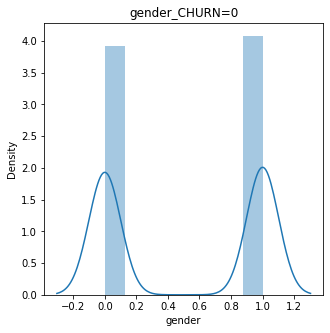

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


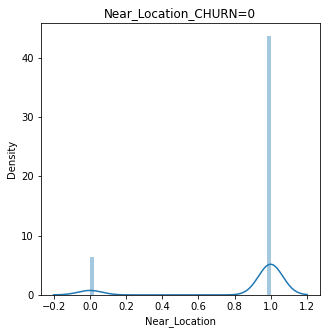

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


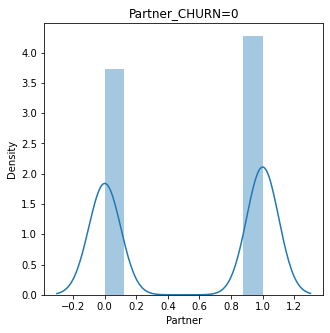

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


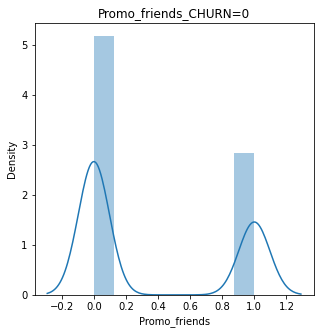

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


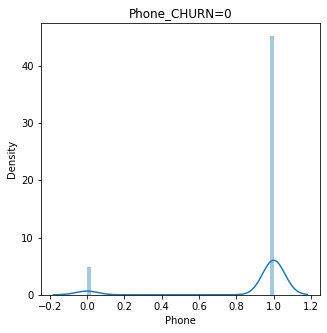

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


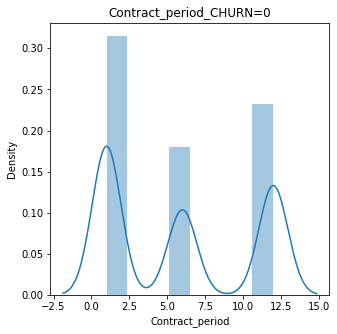

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


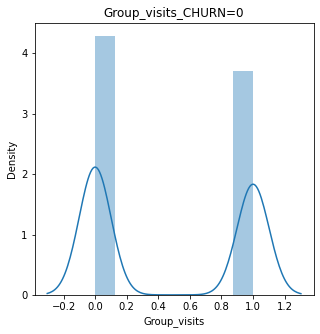

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


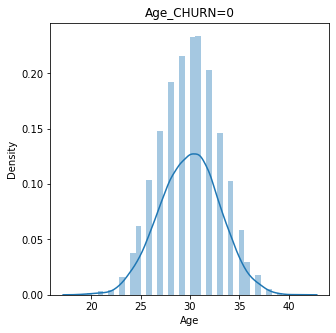

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


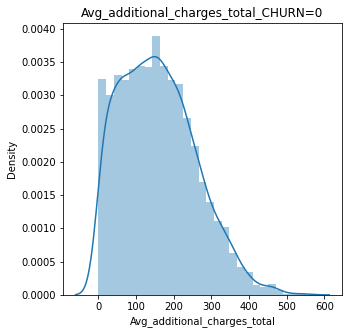

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


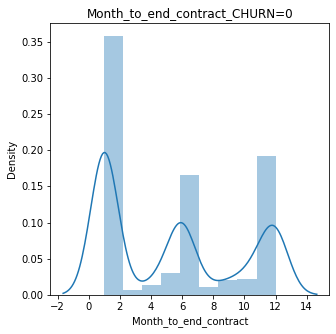

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


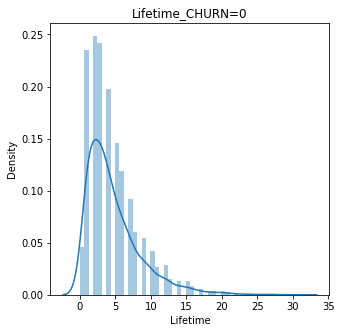

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


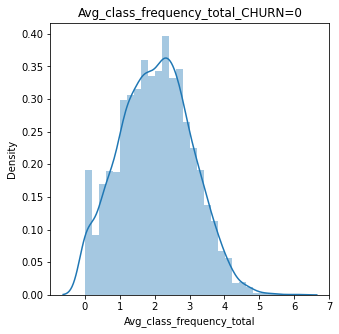

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


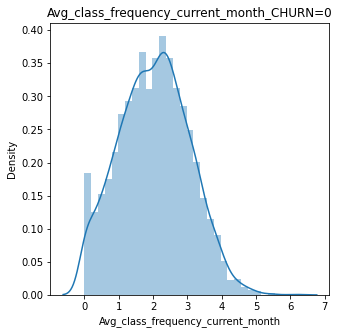

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


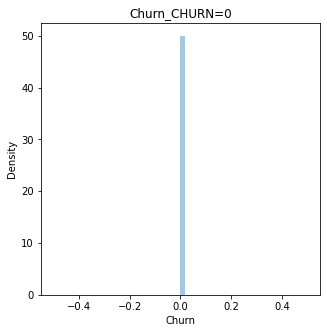

In [6]:
for column in data_0.columns:
    plt.figure(figsize=(5, 5))
    sns.distplot(data_0[column])
    plt.title(column+'_CHURN=0')
    plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


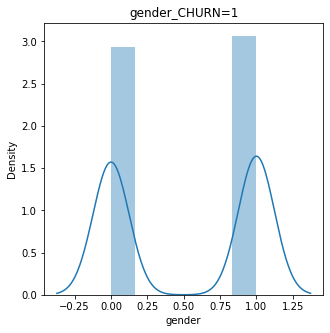

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


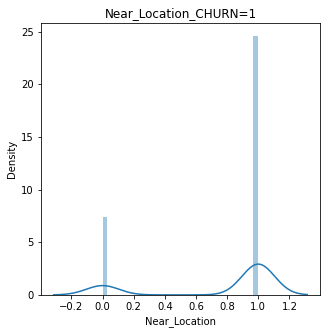

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


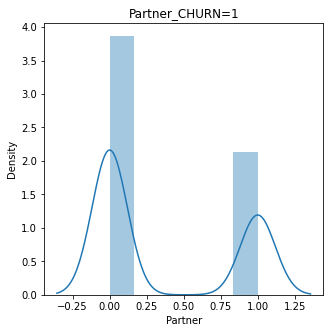

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


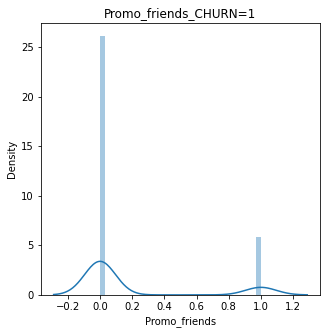

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


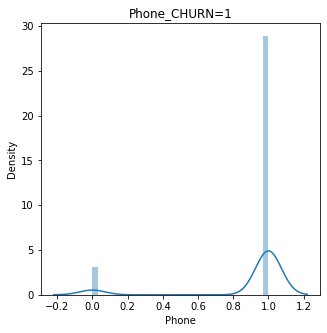

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


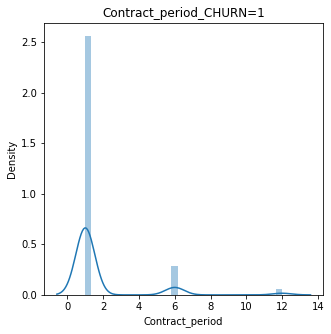

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


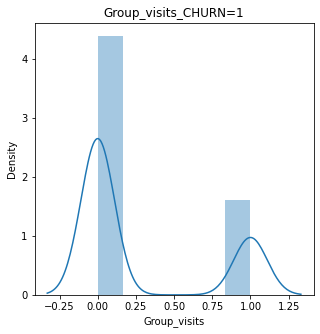

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


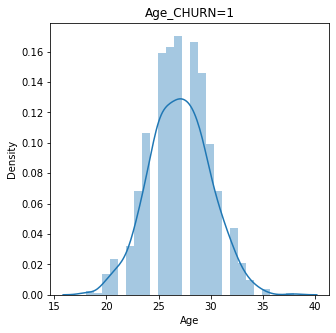

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


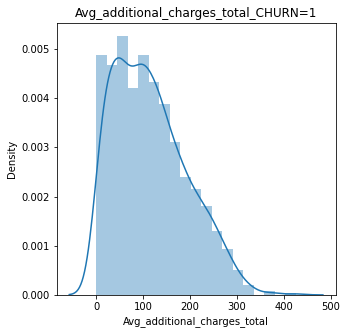

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


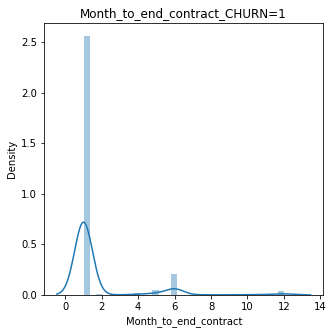

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


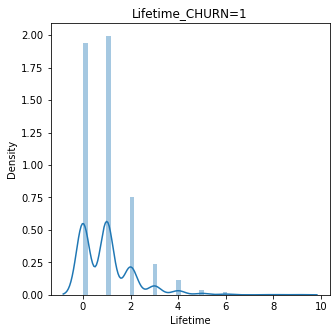

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


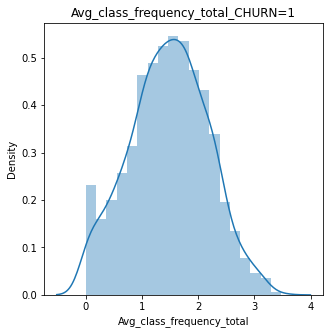

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


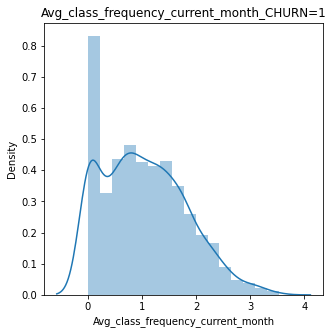

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


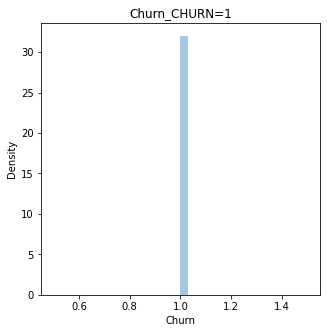

In [7]:
for column in data_1.columns:
    plt.figure(figsize=(5, 5))
    sns.distplot(data_1[column])
    plt.title(column+'_CHURN=1')
    plt.show()

По диаграмме уже можно предположить, какие признаки могут повлиять на отток. Стоит понаблюдать за признаком расположения, посещение групповых занятий. Также характерно выделяются абонементы на месяц, полгода и годовые.

## Построим матрицу корреляций и отобразим её

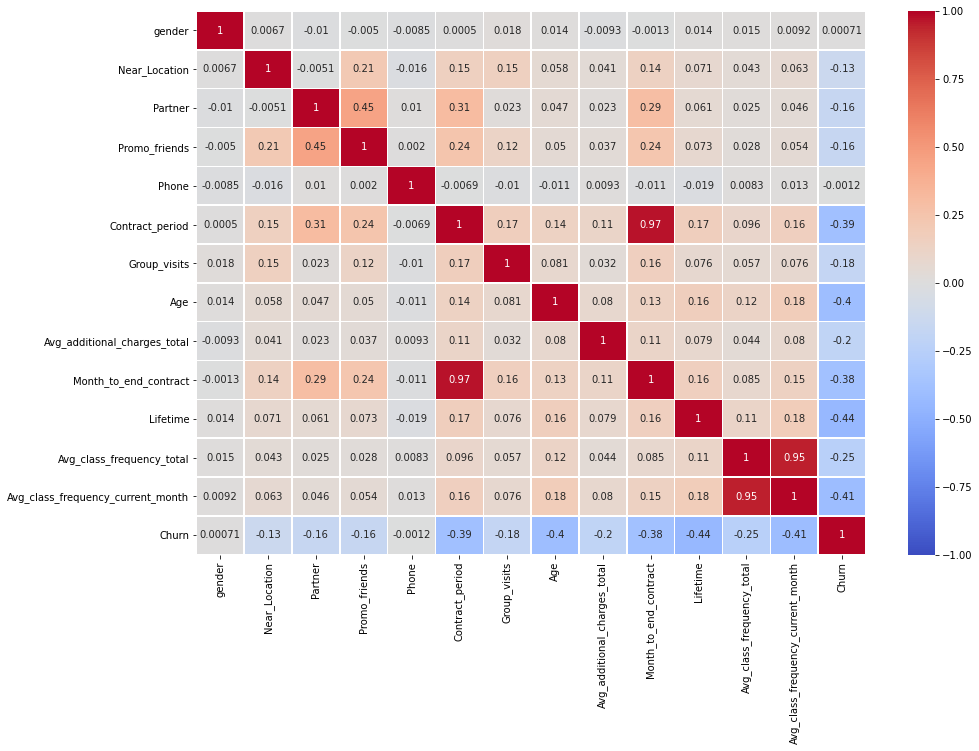

In [8]:
cm = data.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot = True, fmt = '0.2g', vmin=-1, vmax=1, center= 0, linewidths=.5, cmap='coolwarm')
plt.show()

На матрице корреляций наглядно видим как признаки коррелируют друг с другом. У нас только две пары мультиколлинеарных признаков - срок до окончания текущего абонемента с длительностью текущего действующего абонемента, а также средняя частота посещений в неделю за предыдущий месяц с средняя частота посещений в неделю за все время с начала действия абонемента (ну, здесь логично).

- проживающих и работающих недалеко от фитнес-клуба в неск. раз больше
- сотрудников компании-партнёра клуба немного больше из тех, кто остается
- по акции "приведи друга" в 2 раза меньше среди ушедших
- посещающих групповые занятия больше среди тех, кто остается

# Построим модель прогнозирования оттока клиентов

## Разобьём данные на обучающую и валидационную выборку функцией train_test_split()

In [9]:
# разделяем данные на признаки (матрица X) и целевую переменную (y)

X = data.drop('Churn', axis = 1)
y = data['Churn']

# разделяем модель на обучающую и валидационную выборку (в соотношении 80\20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Обучим модель на train-выборке двумя способами: логистической регрессией и случайным лесом

In [10]:
model = LogisticRegression(random_state=0, solver='liblinear') # используем логистическую регрессию

model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [11]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) # используем случайный лес
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

## Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели. Какая модель показала себя лучше на основании метрик?

In [12]:
# оценим модель Логистическая регрессия

predictions = model.predict(X_test)
probabilities =  model.predict_proba(X_test)[:,1]

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))

Accuracy: 0.93
Precision: 0.86
Recall: 0.83


In [13]:
# оценим модель Случайный лес

rf_predictions = rf_model.predict(X_test) 
rf_probabilities = rf_model.predict_proba(X_test)[:,1]

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))

Accuracy: 0.92
Precision: 0.84
Recall: 0.82


Модель Логистическая регрессия выглядит гораздо лучше на основании метрик.

# Сделаем кластеризацию клиентов

## Стандартизируем данные

In [14]:
# обучим StandartScaler
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

## Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму. На основании полученного графика предположим, какое количество кластеров можно выделить

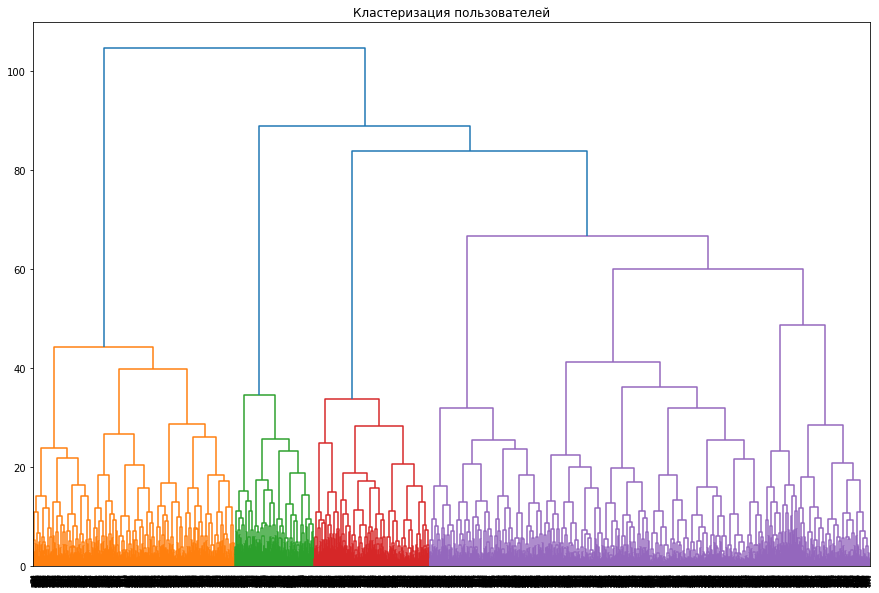

In [15]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация пользователей')
plt.show()

У нас получилось 4 кластера. 

## Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. Примем за число кластеров n=5

In [16]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)

# прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
data['cluster_km'] = labels

## Посмотрим на средние значения признаков для кластеров. Можно ли сразу что-то заметить?

In [17]:
data.groupby('cluster_km').mean().T

cluster_km,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
Near_Location,0.959406,0.862338,0.000000,1.000000,0.976134
Partner,0.783168,0.470130,0.463366,0.350238,0.356802
Promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
Phone,1.000000,0.000000,1.000000,1.000000,0.998807
Contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
Group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
Age,29.982178,29.301299,28.477228,28.167987,30.125298
Avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
Month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


Кластеры не равнозначны по количеству клиентов и по доле оттока. В среднем слабее оттекают кластеры 0 и 4. В кластерах 2 и 3 самый большой отток.

## Построим распределения признаков для кластеров. Можно ли что-то заметить по ним?

In [18]:
data_new = data[['Near_Location', 'Lifetime', 'Partner', 'Promo_friends', 'Contract_period', 'cluster_km', 'Churn', 'Age', 'Month_to_end_contract']]

In [19]:
data['Age'].max()

41

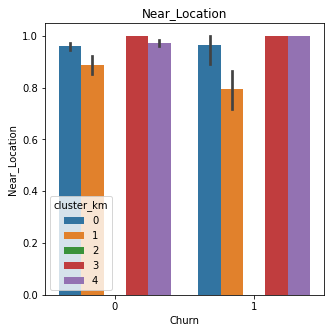

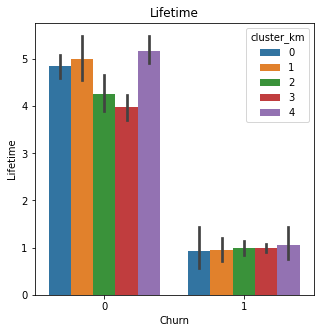

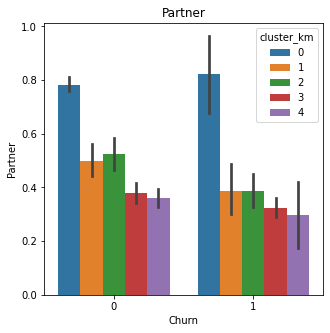

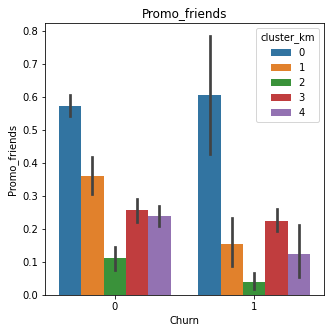

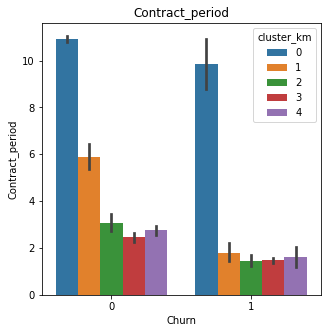

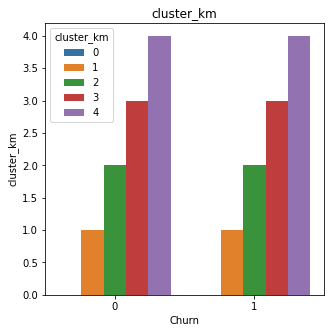

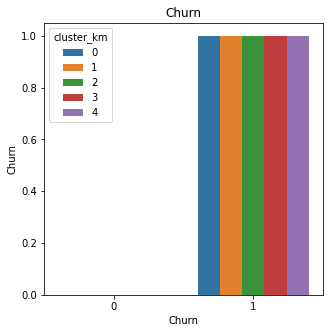

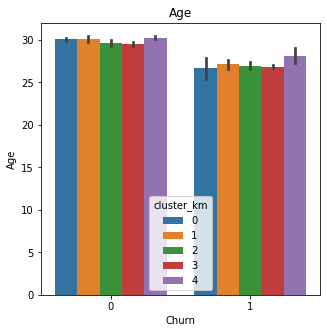

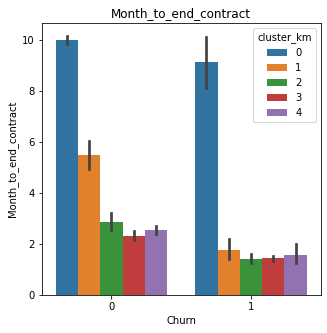

In [20]:
for column in data_new.columns:
    plt.figure(figsize=(5, 5))
    sns.barplot(x='Churn', y=column, hue='cluster_km', data=data_new)
    plt.title(column)
    plt.show()

Распределение по кластерам в среднем:

- Кластер 0: возраст 26-30, срок окончания текущего абонемента 9-10 мес., Lifetime 1-5 мес., доля оттока 5.4%
- Кластер 1: возраст 26-30, срок окончания текущего абонемента 2-6 мес., Lifetime 1-5 мес., доля оттока 61.1%
- Кластер 2: возраст 26-29, срок окончания текущего абонемента 1-3 мес., Lifetime 1-4 мес., доля оттока 21.1%
- Кластер 3: возраст 26-29, срок окончания текущего абонемента 1-2 мес., Lifetime 1-4 мес., доля оттока 9.7%
- Кластер 4: возраст 27-30, срок окончания текущего абонемента 1-2 мес., Lifetime 1-4 мес., доля оттока 2.6%

## Для каждого полученного кластера посчитаем долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [21]:
data_cl = data.groupby('cluster_km').agg({'Churn':'sum'}).sort_values(by='cluster_km', ascending=False).reset_index()
data_cl['percent'] = data_cl['Churn'] / data_cl['Churn'].sum()
data_cl

,cluster_km,Churn,percent
0,4,57,0.053723
1,3,649,0.611687
2,2,224,0.211122
3,1,103,0.097078
4,0,28,0.026390


Более всего к оттоку склонен кластер 3, он явный лидер по этому показателю.
Наиболее стабильны 0 и 4 кластер.

# Сформулируем выводы и сделаем базовые рекомендации по работе с клиентами

- Для привлечения клиентов стараться ориентироваться на стабильные кластеры
- Поддерживать и мотивировать стабильные кластеры, не пускать на "самотек"
- Глубже сегментировать оттекающий кластер, по каждому сегменту тестировать индивидуальные предложения
- К оттоку склонны молодые люди 26-30 лет. Для удержания стоит уделить внимание это возрастной группе, постараться выявить то, что их не устраивает в клубе
- Также, к оттоку склонны те, кто не посещает групповые занятия. Возможно, стоит добавить какие-то виды занятий или доработать спецпредложение "Приведи друга" с посещением груп.зантятий
- Если люди уходит, то в основном через 1-2 мес. после первого посещения. Нужно на это время особо уделить внимание клиентам, их нуждам. Постараться сделать так, чтобы они максимально успели ознакомиться со всеми возможностями клуба за это время + по возможности брать обратную связь от клиентов
- Наладить аналитику и стараться предупреждать отток клиентов, это проще, чем потом их возвращать